# Defining and using short-range wakefields 

In [1]:
%plot -f SVG

In [2]:
RF_Track;


RF-Track, version 2.3.3a0

Copyright (C) 2016-2025 CERN, Geneva, Switzerland. All rights reserved.

Author and contact:
 Andrea Latina <andrea.latina@cern.ch>
 BE-ABP Group
 CERN
 CH-1211 GENEVA 23
 SWITZERLAND

This software is distributed under a CERN proprietary software
license in the hope that it will be useful, but WITHOUT ANY WARRANTY;
not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

See the COPYRIGHT and LICENSE files at the top-level directory of
the RF-Track download area: https://gitlab.cern.ch/rf-track

RF-Track was compiled with GSL-2.7 and fftw-3.3.10



## Define a short-range wakefield

RF-Track implements several wakefield models. One of the most useful is provided by ```ShortRangeWakefield```, which implements K. Bane's approximation, described in [SLAC-PUB-9663, 2003]

It models the wakefields are defined using the key structure's geometric parameters:
* $a$, the iris aperture radius in m
* $g$, the gap length in m
* $l$, the cell length in m
<div style="text-align:center"><img src="extras/SRWF_cell.png" alt="Parameters" width="200"/></div>

In evaluating the wakefield effect, $W_\perp(s)$ has been calculated using the analytic approximation of the wake potential presented in [K.Bane, SLAC-PUB-9663, 2003] applied to a two-particle beam model such as
\begin{align*}
W_{\perp}(s) & =\dfrac{4Z_{0}cs_{\perp0}}{\pi a^{4}}\left[1-\left(1+\sqrt{\frac{s}{s_{\perp0}}}\right)\exp\left(-\sqrt{\frac{s}{s_{\perp0}}}\right)\right],\\
W_{\parallel}(s) & =\frac{4Z_{0}c}{\pi a^{2}}\exp\left(-\sqrt{\dfrac{s}{s_{\parallel0}}}\right),
\end{align*}
where $Z_0 =120\,\pi \Omega$ is the impedance of free space, $a$ is the average aperture radius of the structure, $g$ is the gap length, $d$ is the length of the cell, $s_{\parallel 0}=0.41 {a^{0.18} g^{1.6}} / {d^{2.5}}$ and   $s_{\perp 0}=1.69 {a^{1.79} g^{0.38}} / {d^{1.17}}$. Its range of validity generally covers most of the cases.


In [3]:
a = 0.002; % m, iris aperture radius
g = 0.005; % m, gap length
l = 0.006; % m, cell length

SRWF = ShortRangeWakefield (a, g, l); % a,g,l

In [4]:
SRWF.w_transv(-0.001)

ans = -904.34


We can plot the wake function

In [5]:
Z = linspace(-0.001, 0, 1001);

Wt = [];
Wl = [];

for z = Z
    Wt = [ Wt ; SRWF.w_transv(z) ]; % V/pC/m/mm
    Wl = [ Wl ; SRWF.w_long(z) ]; % V/pC/m
end

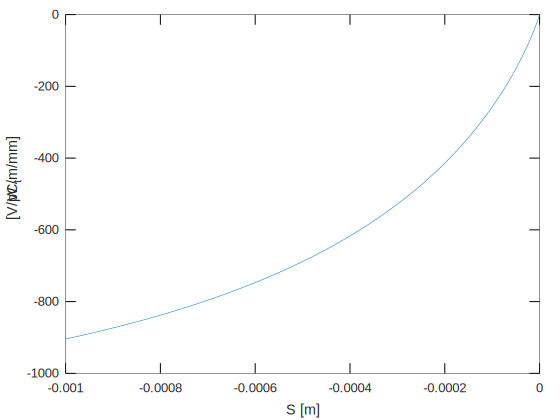

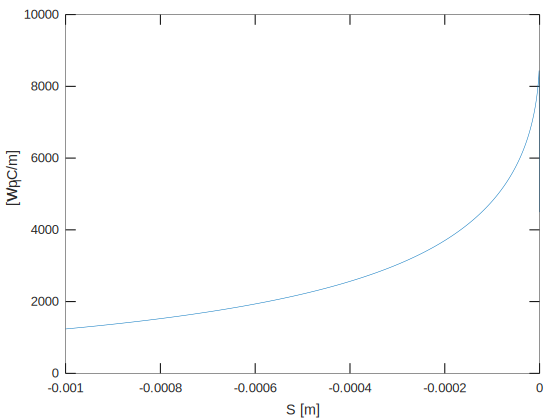

In [6]:
figure
plot(Z, Wt)
xlabel('S [m]')
ylabel('W_t [V/pC/m/mm]')

figure
plot(Z, Wl)
xlabel('S [m]')
ylabel('W_l [V/pC/m]')

### Once defined, we can attach it to an element
As an example, let's attach it to a 1m-long drift

In [7]:
D = Drift (1); % 1m long drift

D.add_collective_effect (SRWF);
D.set_cfx_nsteps(10); % we want to have 10 kicks along the structure

### Now let's create a bunch
Purely longitudinal

In [8]:
sigma_t = 0.1; % mm/c
Pspread = 0.0; % permille, momentum spread
Pref = 50; % MeV/c

Twiss = Bunch6d_twiss();
Twiss.sigma_t = sigma_t; % mm/c
Twiss.sigma_pt = Pspread; % permille

B0 = Bunch6d(RF_Track.electronmass, RF_Track.nC, -1, Pref, Twiss, 1000);

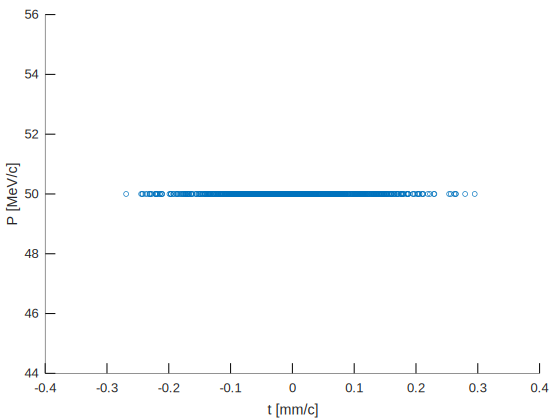

In [9]:
M0 = B0.get_phase_space();

scatter(M0(:,5), M0(:,6))
xlabel('t [mm/c]')
ylabel('P [MeV/c]')
ylim([ 44 56 ])

### and a Lattice

In [10]:
%% lattice
L = Lattice();
L.append(D);

Let's plot the outcoming bunch, for different incoming offsets

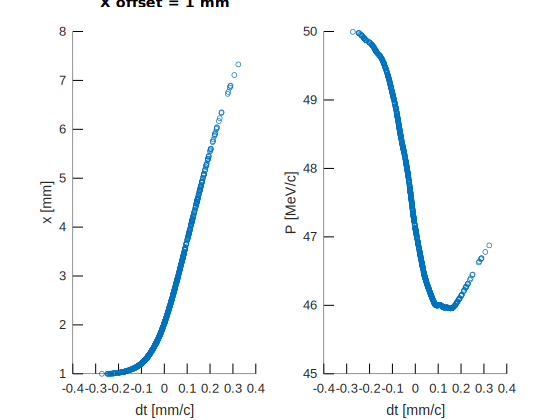

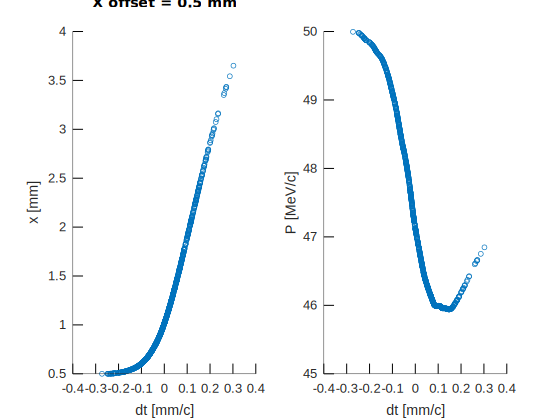

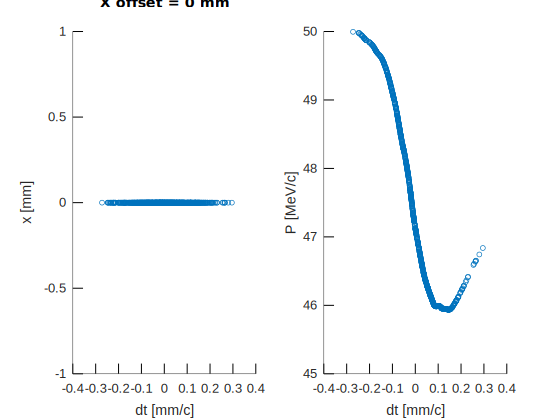

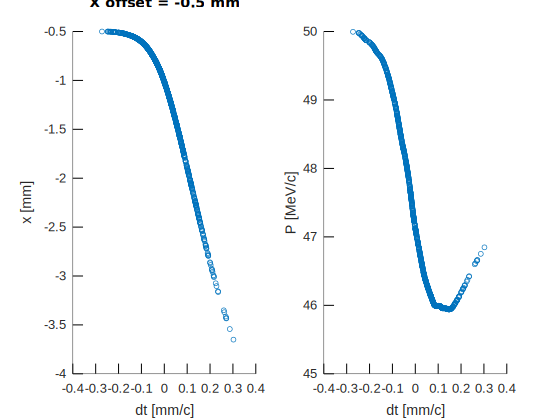

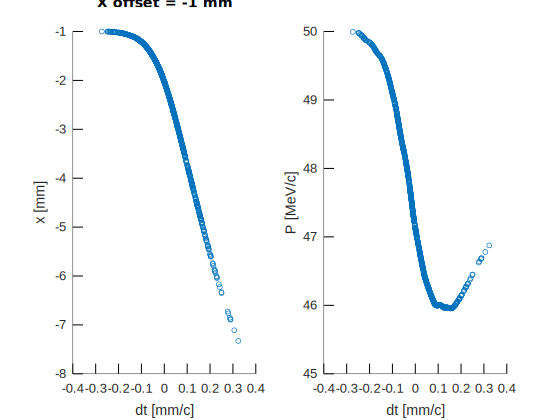

In [11]:
%% main loop
for X = linspace(+1, -1, 5) % mm 

    M0(:,1) = X;
    B0.set_phase_space(M0);
    
    %% track
    B1 = L.track(B0);
    
    %% do plots
    M1 = B1.get_phase_space('%x %xp %y %yp %dt %P');

    figure
    subplot(1,2,1)
    scatter(M1(:,5), M1(:,1))
    xlabel('dt [mm/c]');
    ylabel('x [mm]');
    title([ 'X offset = ' num2str(X) ' mm'])

    subplot(1,2,2)
    scatter(M1(:,5), M1(:,6))
    xlabel('dt [mm/c]');
    ylabel('P [MeV/c]');
end
